In [1]:
#Bibliotecas
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

from utiles import spike_reducer
#spike_recuder
import umap
import umap.plot
from umap import UMAP

##Generar un archivo PKL
import pickle 

##Algoritmosde Clustering

import hdbscan
from sknetwork.clustering import Louvain

# Generate PCKL file

In [2]:
#path_file = "E:\\ExpRecientes\\PRK20220816s01_SPK.h5"
#path_file = "./files/CTR20211101s01A_SPK.h5"
path_file = "/media/yeshua/ZEILER/T_proyect/20230622/datamanager/Rebanada02/OPTOa20230622s02_SPK.h5"
file = h5py.File(path_file)
#['Data']['Recording_0']['SegmentStream']['Stream_0']
Segments = file['Data']['Recording_0']['SegmentStream']['Stream_0']
keys = list(Segments.keys())

min_num_spikes = 100

keys_segments = []
for i in range(0, len(keys)):
    if "SegmentData" in keys[i] and not("ts" in keys[i]) and (Segments[keys[i]].shape[1] >= min_num_spikes):
        keys_segments.append(keys[i])
        print("{} : {} --> {}".format(i, keys[i], Segments[keys[i]].shape[1]))
print("Número de segmentos detectados: {}".format(len(keys_segments)))

1 : SegmentData_0 --> 136
4 : SegmentData_100 --> 180
5 : SegmentData_101 --> 223
6 : SegmentData_102 --> 114
15 : SegmentData_111 --> 210
19 : SegmentData_115 --> 108
22 : SegmentData_118 --> 1310
24 : SegmentData_12 --> 197
26 : SegmentData_14 --> 354
27 : SegmentData_15 --> 323
30 : SegmentData_18 --> 349
31 : SegmentData_19 --> 125
34 : SegmentData_21 --> 395
35 : SegmentData_22 --> 1359
37 : SegmentData_24 --> 135
38 : SegmentData_25 --> 154
39 : SegmentData_26 --> 127
41 : SegmentData_28 --> 237
42 : SegmentData_29 --> 160
44 : SegmentData_30 --> 102
45 : SegmentData_31 --> 419
46 : SegmentData_32 --> 2240
47 : SegmentData_33 --> 144
48 : SegmentData_34 --> 110
51 : SegmentData_37 --> 188
52 : SegmentData_38 --> 111
56 : SegmentData_41 --> 149
61 : SegmentData_46 --> 871
66 : SegmentData_50 --> 275
67 : SegmentData_51 --> 125
71 : SegmentData_55 --> 128
74 : SegmentData_58 --> 5197
79 : SegmentData_62 --> 122
80 : SegmentData_63 --> 219
83 : SegmentData_66 --> 135
84 : SegmentDat

In [4]:
underscore =keys_segments[0].index('_')
electrode = keys_segments[0][underscore+1:]
print("e{}: {}".format(electrode, keys_segments[0]))

e0: SegmentData_0


In [5]:
'''Código para graficar todos las spikes por electrodo'''
'''plt.figure(figsize=(15,6))
for conde in tqdm(range(0, len(keys_segments)), desc ="SpikeData progress ..."):
    underscore =keys_segments[conde].index('_')
    electrode = int(keys_segments[conde][underscore+1:])
    plt.plot(Segments[keys_segments[conde]])
    plt.title("Sipke Data: e{} {}".format(119-electrode,keys_segments[conde]))
    plt.savefig("E:\\ExpRecientes\\SpikesPlots\\e"+str(119-electrode)+keys_segments[conde]+".png")
    plt.clf()
plt.show()'''

'plt.figure(figsize=(15,6))\nfor conde in tqdm(range(0, len(keys_segments)), desc ="SpikeData progress ..."):\n    underscore =keys_segments[conde].index(\'_\')\n    electrode = int(keys_segments[conde][underscore+1:])\n    plt.plot(Segments[keys_segments[conde]])\n    plt.title("Sipke Data: e{} {}".format(119-electrode,keys_segments[conde]))\n    plt.savefig("E:\\ExpRecientes\\SpikesPlots\\e"+str(119-electrode)+keys_segments[conde]+".png")\n    plt.clf()\nplt.show()'

## Timestamps

In [3]:
'''Electrodos con mas de 100 spikes'''
keys_ts = []
for i in range(0, len(keys)):
    if "SegmentData_ts" in keys[i] and (Segments[keys[i]].shape[1] >= min_num_spikes):
        keys_ts.append(keys[i])
        print("{} : {} --> {}".format(i, keys[i], Segments[keys[i]].shape[1]))
print("Número de segmentos detectados: {}".format(len(keys_ts)))

120 : SegmentData_ts_0 --> 136
123 : SegmentData_ts_100 --> 180
124 : SegmentData_ts_101 --> 223
125 : SegmentData_ts_102 --> 114
134 : SegmentData_ts_111 --> 210
138 : SegmentData_ts_115 --> 108
141 : SegmentData_ts_118 --> 1310
143 : SegmentData_ts_12 --> 197
145 : SegmentData_ts_14 --> 354
146 : SegmentData_ts_15 --> 323
149 : SegmentData_ts_18 --> 349
150 : SegmentData_ts_19 --> 125
153 : SegmentData_ts_21 --> 395
154 : SegmentData_ts_22 --> 1359
156 : SegmentData_ts_24 --> 135
157 : SegmentData_ts_25 --> 154
158 : SegmentData_ts_26 --> 127
160 : SegmentData_ts_28 --> 237
161 : SegmentData_ts_29 --> 160
163 : SegmentData_ts_30 --> 102
164 : SegmentData_ts_31 --> 419
165 : SegmentData_ts_32 --> 2240
166 : SegmentData_ts_33 --> 144
167 : SegmentData_ts_34 --> 110
170 : SegmentData_ts_37 --> 188
171 : SegmentData_ts_38 --> 111
175 : SegmentData_ts_41 --> 149
180 : SegmentData_ts_46 --> 871
185 : SegmentData_ts_50 --> 275
186 : SegmentData_ts_51 --> 125
190 : SegmentData_ts_55 --> 128


In [5]:
for i in range (0, len(keys_segments)):
    print("{:<2}: {:<16} {:<18} size : {}, {}".format(i, 
                                                   keys_segments[i], 
                                                   keys_ts[i],
                                                   Segments[keys_segments[i]].shape[1],
                                                   Segments[keys_ts[i]].shape[1]))

0 : SegmentData_0    SegmentData_ts_0   size : 136, 136
1 : SegmentData_100  SegmentData_ts_100 size : 180, 180
2 : SegmentData_101  SegmentData_ts_101 size : 223, 223
3 : SegmentData_102  SegmentData_ts_102 size : 114, 114
4 : SegmentData_111  SegmentData_ts_111 size : 210, 210
5 : SegmentData_115  SegmentData_ts_115 size : 108, 108
6 : SegmentData_118  SegmentData_ts_118 size : 1310, 1310
7 : SegmentData_12   SegmentData_ts_12  size : 197, 197
8 : SegmentData_14   SegmentData_ts_14  size : 354, 354
9 : SegmentData_15   SegmentData_ts_15  size : 323, 323
10: SegmentData_18   SegmentData_ts_18  size : 349, 349
11: SegmentData_19   SegmentData_ts_19  size : 125, 125
12: SegmentData_21   SegmentData_ts_21  size : 395, 395
13: SegmentData_22   SegmentData_ts_22  size : 1359, 1359
14: SegmentData_24   SegmentData_ts_24  size : 135, 135
15: SegmentData_25   SegmentData_ts_25  size : 154, 154
16: SegmentData_26   SegmentData_ts_26  size : 127, 127
17: SegmentData_28   SegmentData_ts_28  size

In [6]:
#Crear un diccionario 
'''keys = SegmentData_#
   values = list [np.spikes, np.ts, #]'''

#empty diccionary
experiment = {}


# np.array(Segments[keys_segments[i]]).T--> spike profile
# np.array(Segments[keys_ts[i]]).T

for i in range (0, len(keys_segments)):
    underscore = keys_segments[i].index('_')
    num_seg = int(keys_segments[i][underscore+1:])
    experiment[keys_segments[i]] = [np.array(Segments[keys_segments[i]]).T,
                                    np.array(Segments[keys_ts[i]]).T,
                                    num_seg]

# Escritura en modo binario, vacía el fichero si existe
#name_pckl = './files/CTR20211101s01A_SPK.pckl'

name_pckl = "/media/yeshua/ZEILER/T_proyect/20230622/datamanager/Rebanada02/OPTOa20230622s02_SPK.pckl"

pckl_file = open(name_pckl,'wb')
# Escribe la colección en el fichero 
pickle.dump(experiment, pckl_file) 
pckl_file.close()

# UMAP

In [7]:
#name = './files/CTR20211101s01A_SPK.pckl'
name = "/media/yeshua/ZEILER/T_proyect/20230622/datamanager/Rebanada02/OPTOa20230622s02_SPK.pckl"
charge_pckl = open(name,'rb') 
# Charge pckl file
experiment_pckl = pickle.load(charge_pckl)
charge_pckl.close()
k_pckl = list(experiment_pckl.keys())

In [9]:
experiment_pckl['SegmentData_88'][0]

array([[ -11,  -32,   26, ..., 1233, 1039,  893],
       [-467, -444, -455, ..., -258, -175,  -12],
       [ -63,  -56,   21, ...,  -56,  -95,   12],
       ...,
       [  80,   28,  -68, ...,  -62, -150,  -97],
       [ -52,  -17,   75, ...,  128,  281,  259],
       [ -58,   22,  152, ...,   -8,  -51,  -74]], dtype=int32)

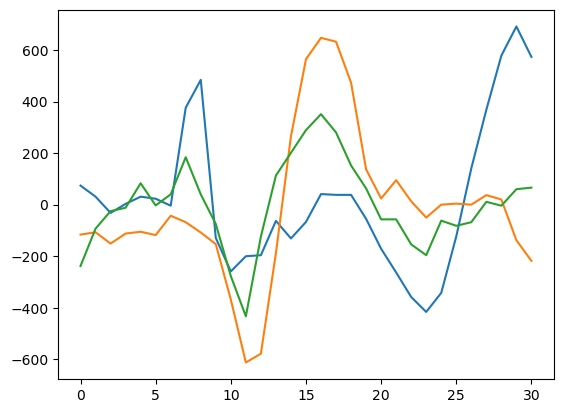

In [37]:
#Segment Number
segment_selection = 2
#plt.plot(experiment_pckl[k_pckl[segment_selection]][0].T)
plt.plot(experiment_pckl['SegmentData_32'][0][0:3].T)
plt.show()

#experiment_pckl['SegmentData_#'][0].T --> datos de los segmentos
#experiment_pckl['SegmentData_#'][1].T --> datos de timestamps

In [ ]:
#index = 0
#tqdm(range(0, len(keys_segments)), desc ="SpikeData progress ..."):
for index in tqdm(range(0, len(k_pckl)), desc ="UMAP process ..."):
    if (k_pckl[index] != 'SegmentData_36') and (k_pckl[index] != 'SegmentData_42') and (k_pckl[index] != 'SegmentData_46') :
        fig, axs = plt.subplots(2, figsize=(15,15), gridspec_kw={'height_ratios': [1, 2]})

        fig.suptitle("UMAP: {}".format(k_pckl[index]))

        axs[0].plot(experiment_pckl[k_pckl[index]][0].T, linewidth=0.1, color = 'forestgreen')
        axs[0].title.set_text('Spike Profile')
        axs[0].set(ylabel='Voltage')

        reduced_spikes = spike_reducer(experiment_pckl[k_pckl[index]][0], v_neighbors = 35, random_state = 18)
        spike_embedding = reduced_spikes.embedding_
        for j in range(0, len(spike_embedding)):
            axs[1].plot(spike_embedding[j][0],spike_embedding[j][1] , marker="o", color = "dodgerblue")
        axs[1].title.set_text('Dimension Reduction')

        matplotlib.pyplot.savefig("/home/yeshua/Documentos/tesis/CTR_20211101imagenes/UMAP{}.png".format(k_pckl[index]))
        matplotlib.pyplot.close()


UMAP process ...:  38%|██████████████████████████████▍                                                  | 12/32 [06:17<14:56, 44.84s/it]

In [6]:
#Creación de archivos
    #Algoritmo de agrupamiento HDBSCAN ¿que necesita?
    

reduced_spikes = spike_reducer(experiment_pckl['SegmentData_104'][0], v_neighbors = 35, random_state = 18)
spike_embedding = reduced_spikes.embedding_
spike_embedding

array([[10.948458 ,  4.20682  ],
       [11.495288 ,  7.202148 ],
       [11.231842 ,  4.197785 ],
       ...,
       [10.703925 ,  4.285361 ],
       [14.481659 ,  2.5193233],
       [ 4.4337683,  8.590023 ]], dtype=float32)

Text(0.5, 1.0, 'Dimension Reduction')

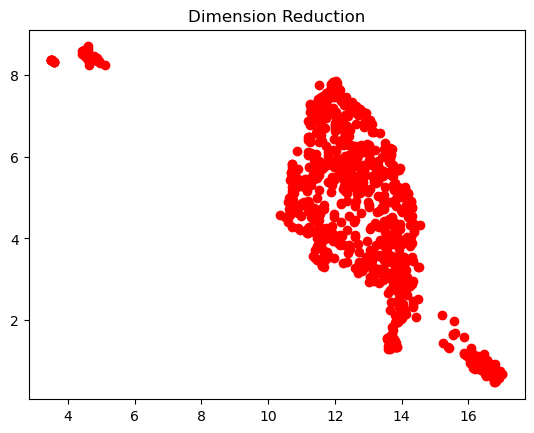

In [7]:
for i in range(0, len(spike_embedding)):
    plt.plot(spike_embedding[i][0],spike_embedding[i][1] , marker="o", color = "red")
plt.title('Dimension Reduction')

In [8]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(spike_embedding)

HDBSCAN()

In [9]:
clusterer.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Text(0.5, 1.0, 'Dimension Reduction')

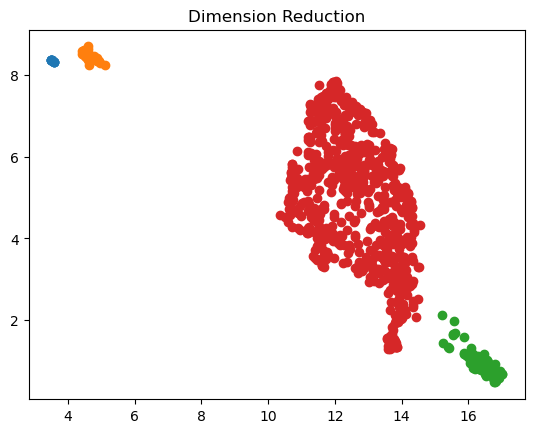

In [10]:
colores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i in range(0, len(spike_embedding)):
    plt.plot(spike_embedding[i][0],spike_embedding[i][1] , marker="o", color = colores[clusterer.labels_[i]])
plt.title('Dimension Reduction')

In [22]:
len(experiment_pckl['SegmentData_104'][0])

803

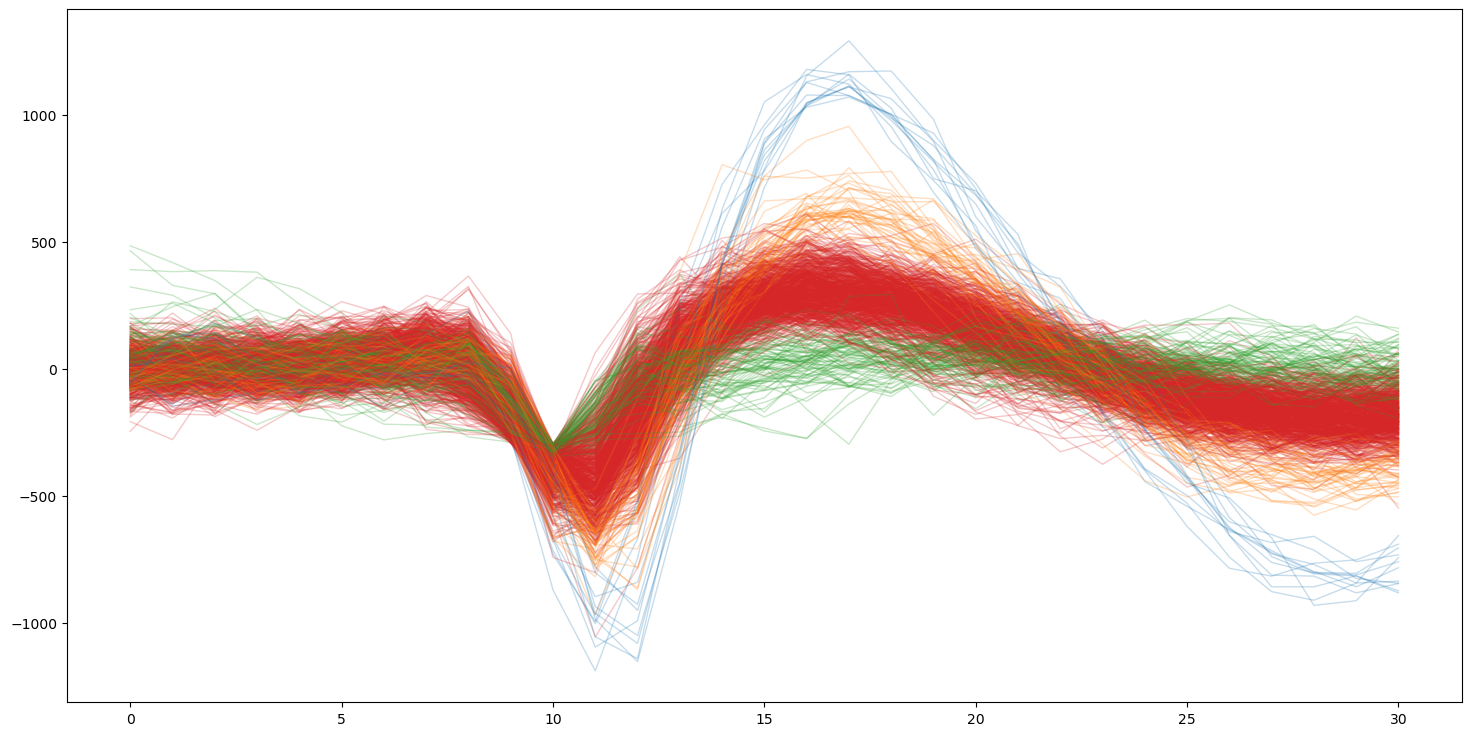

In [28]:
plt.figure(figsize=(18,9))
for i in range (0, len(experiment_pckl['SegmentData_104'][0])):
    plt.plot(experiment_pckl['SegmentData_104'][0][i].T, color = colores[clusterer.labels_[i]], linewidth=1, alpha =0.25)

# mini GUI

In [51]:
##Generate pckl file
def genpcklfile (path_file, min_num_spikes = 100, ):
    file = h5py.File(path_file)
    Segments = file['Data']['Recording_0']['SegmentStream']['Stream_0']
    keys = list(Segments.keys())
    keys_segments = []
    keys_ts = []
    
    for i in range(0, len(keys)):
        if "SegmentData" in keys[i] and not ("ts" in keys[i]) and (Segments[keys[i]].shape[1] >= min_num_spikes):
            keys_segments.append(keys[i])
        elif "SegmentData_ts" in keys[i] and (Segments[keys[i]].shape[1] >= min_num_spikes):
            keys_ts.append(keys[i])
            
    #Crear un diccionario
    '''keys = SegmentData_# 
    values = list [np.spikes, np.ts, #]'''
    experiment = {}
    
    # np.array(Segments[keys_segments[i]]).T--> spike profile
    # np.array(Segments[keys_ts[i]]).T
    for i in range (0, len(keys_segments)):
        underscore = keys_segments[i].index('_')
        num_seg = int(keys_segments[i][underscore+1:])
        experiment[keys_segments[i]] = [np.array(Segments[keys_segments[i]]).T,
                                        np.array(Segments[keys_ts[i]]).T,
                                        num_seg]
        
        print("{:<2}: {:<16} {:<18} size : {}, {}".format(i, 
                                                       keys_segments[i], 
                                                       keys_ts[i],
                                                       Segments[keys_segments[i]].shape[1],
                                                       Segments[keys_ts[i]].shape[1]))
    
    # Escritura en modo binario, vacía el fichero si existe
    dotindex = path_file.rfind(".")
    if dotindex == -1:
        print("Error name pckl ...")
    else:
        name_pckl = path_file[0:dotindex]+'.pckl'
        pckl_file = open(name_pckl,'wb')
        # Escribe la colección en el fichero 
        pickle.dump(experiment, pckl_file) 
        pckl_file.close()
        print("File create :)")

In [52]:
genpcklfile('./files/CTR20211101s01C_SPK.h5',100)

0 : SegmentData_1    SegmentData_ts_1   size : 116, 116
1 : SegmentData_103  SegmentData_ts_103 size : 101, 101
2 : SegmentData_104  SegmentData_ts_104 size : 279, 279
3 : SegmentData_106  SegmentData_ts_106 size : 202, 202
4 : SegmentData_108  SegmentData_ts_108 size : 647, 647
5 : SegmentData_111  SegmentData_ts_111 size : 339, 339
6 : SegmentData_112  SegmentData_ts_112 size : 216, 216
7 : SegmentData_114  SegmentData_ts_114 size : 106, 106
8 : SegmentData_115  SegmentData_ts_115 size : 138, 138
9 : SegmentData_116  SegmentData_ts_116 size : 132, 132
10: SegmentData_118  SegmentData_ts_118 size : 46612, 46612
11: SegmentData_21   SegmentData_ts_21  size : 113, 113
12: SegmentData_34   SegmentData_ts_34  size : 48861, 48861
13: SegmentData_4    SegmentData_ts_4   size : 122, 122
14: SegmentData_49   SegmentData_ts_49  size : 785, 785
15: SegmentData_5    SegmentData_ts_5   size : 162, 162
16: SegmentData_61   SegmentData_ts_61  size : 74341, 74341
17: SegmentData_62   SegmentData_ts_

Cluster encontrados: [0, 1, 2, 3, -1]
Spikes detected: 2240


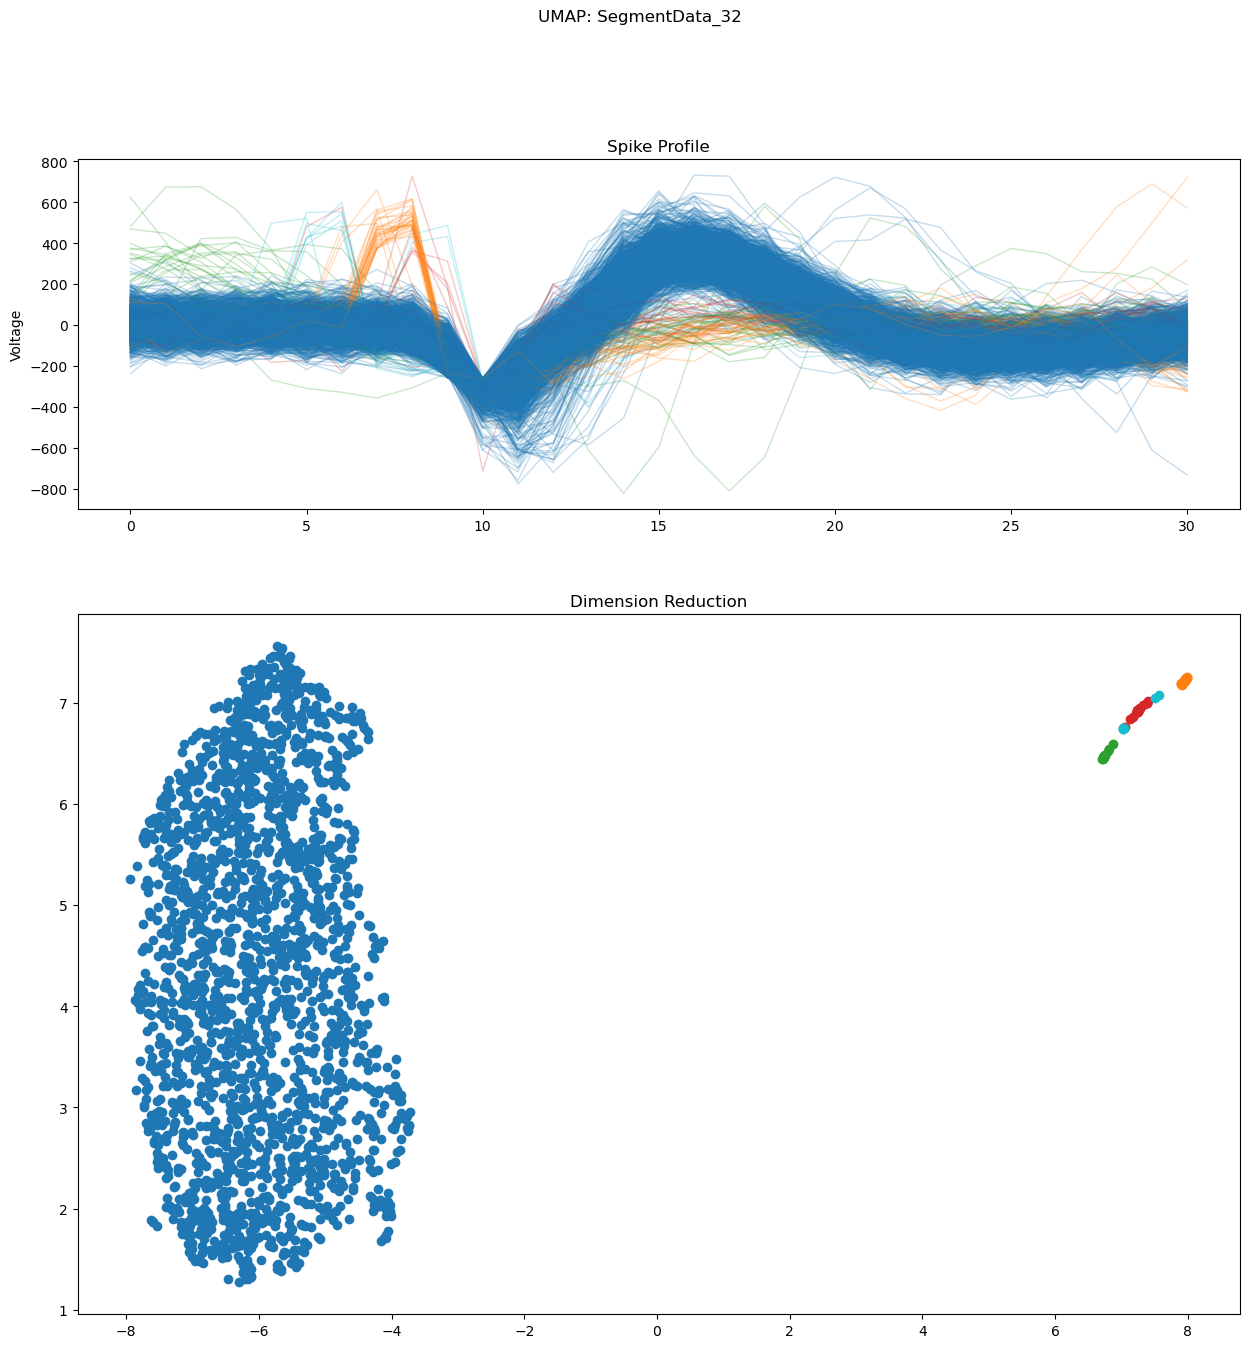

In [23]:
# mini GUI 
# gamma 0.85 0.9 para 
'''Analisis para un solo '''
segment = 'SegmentData_32'
mode = 'All'
cluster_list = [1]

#name = './files/CTR20211101s01B_SPK.pckl'
name = "/media/yeshua/ZEILER/T_proyect/20230622/datamanager/Rebanada02/OPTOa20230622s02_SPK.pckl"

colores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

charge_pckl = open(name,'rb') 
# Charge pckl file
experiment_pckl = pickle.load(charge_pckl)
charge_pckl.close()
k_pckl = list(experiment_pckl.keys())

#UMAP
reduced_spikes = spike_reducer(experiment_pckl[segment][0], v_neighbors = 35, random_state = 18)
spike_embedding = reduced_spikes.embedding_
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
clusterer.fit(spike_embedding)



fig, axs = plt.subplots(2, figsize=(15,15), gridspec_kw={'height_ratios': [1, 2]})

fig.suptitle("UMAP: {}".format(segment))


axs[0].title.set_text('Spike Profile')
axs[0].set(ylabel='Voltage')

axs[1].title.set_text('Dimension Reduction')



for j in range(0, len(experiment_pckl[segment][0])):
    
    
    
    if mode == "All":
        axs[0].plot(experiment_pckl[segment][0][j].T, color = colores[clusterer.labels_[j]], linewidth=1, alpha =0.25)
        axs[1].plot(spike_embedding[j][0],spike_embedding[j][1] , marker="o", color = colores[clusterer.labels_[j]])
        
    elif mode == "OneColor":
        if clusterer.labels_[j] in cluster_list:
            axs[0].plot(experiment_pckl[segment][0][j].T, color = colores[clusterer.labels_[j]], linewidth=1, alpha =0.25)
            axs[1].plot(spike_embedding[j][0],spike_embedding[j][1] , marker="o", color = colores[clusterer.labels_[j]])
        else:
            axs[0].plot(experiment_pckl[segment][0][j].T, color = "gray", linewidth=1, alpha =0.1)
            axs[1].plot(spike_embedding[j][0],spike_embedding[j][1] , marker="o", color = "gray")
    
    #Solo graficas un cluster

cluster_dict = {} 
num_clusters = list(set(clusterer.labels_))

print("Cluster encontrados: {}".format(num_clusters))
print("Spikes detected: {}".format(len(experiment_pckl[segment][0])))
for i in range(0, len(num_clusters)):
    cluster_dict[num_clusters[i]] = []
for i in range(0, len(experiment_pckl[segment][0])):
    cluster_dict[clusterer.labels_[i]].append(i)

In [33]:
experiment_pckl['SegmentData_32'][1]

array([[  9001200],
       [  9007800],
       [  9011300],
       ...,
       [599191600],
       [599200200],
       [599207000]])

Cluster 0: num spikes 49
Cluster 1: num spikes 1659


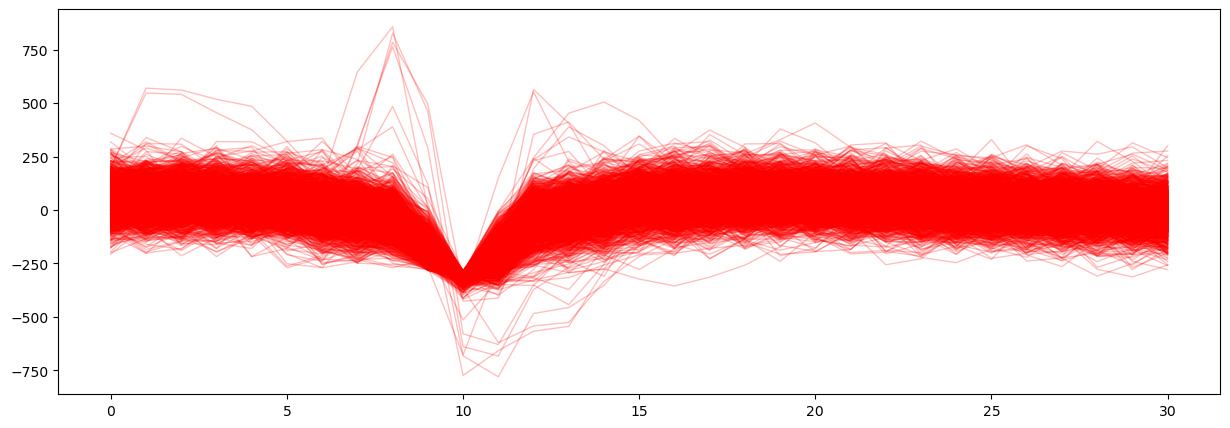

In [56]:
keys = list(cluster_dict.keys())

for i in range(0, len(cluster_dict)):
    print("Cluster {}: num spikes {}".format(keys[i],len(cluster_dict[i])))
'''print("Cluster {}: num spikes {}".format(keys[0],len(cluster_dict[0])))
print("Cluster {}: num spikes {}".format(keys[1],len(cluster_dict[1])))
print("Cluster {}: num spikes {}".format(keys[2],len(cluster_dict[2])))
print("Cluster {}: num spikes {}".format(keys[3],len(cluster_dict[3])))'''
#print("Total                 {}".format(len(cluster_dict[0])+len(cluster_dict[1])+len(cluster_dict[2])+len(cluster_dict[3])))

plt.figure(figsize=(15,5))
for i in range(0, len(cluster_dict[1])):
    index = cluster_dict[1][i]
    plt.plot(experiment_pckl[segment][0][index].T, 
             color = "red", 
             linewidth=1, alpha =0.25)

In [8]:
#experiment_pckl
#reduced_spikes = spike_reducer(experiment_pckl[segment][0], v_neighbors = 35, random_state = 18)
segment = 'SegmentData_86'
labels = Louvain.fit_predict(experiment_pckl[segment][0])
len(set(labels))

AttributeError: 'numpy.ndarray' object has no attribute 'fit'

In [6]:
from sknetwork.data import karate_club

In [7]:
adjacency = karate_club()
adjacency

<34x34 sparse matrix of type '<class 'numpy.bool_'>'
	with 156 stored elements in Compressed Sparse Row format>